<a href="https://colab.research.google.com/github/asrenninger/urbansim/blob/main/streets/ghana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install -q osmnx pyrosm

In [3]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

In [4]:
# download the graph using osmnx
%time G = ox.graph_from_place('Ghana', network_type='drive', simplify=True)

/usr/local/lib/python3.11/dist-packages/osmnx/_overpass.py:267: UserWarning: This area is 117 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


CPU times: user 18min 48s, sys: 24.3 s, total: 19min 12s
Wall time: 24min 38s


In [6]:
# get the node, edge geometries
N, E = ox.graph_to_gdfs(G)

# project the network to web mercator
N = N.to_crs(3857)
E = E.to_crs(3857)

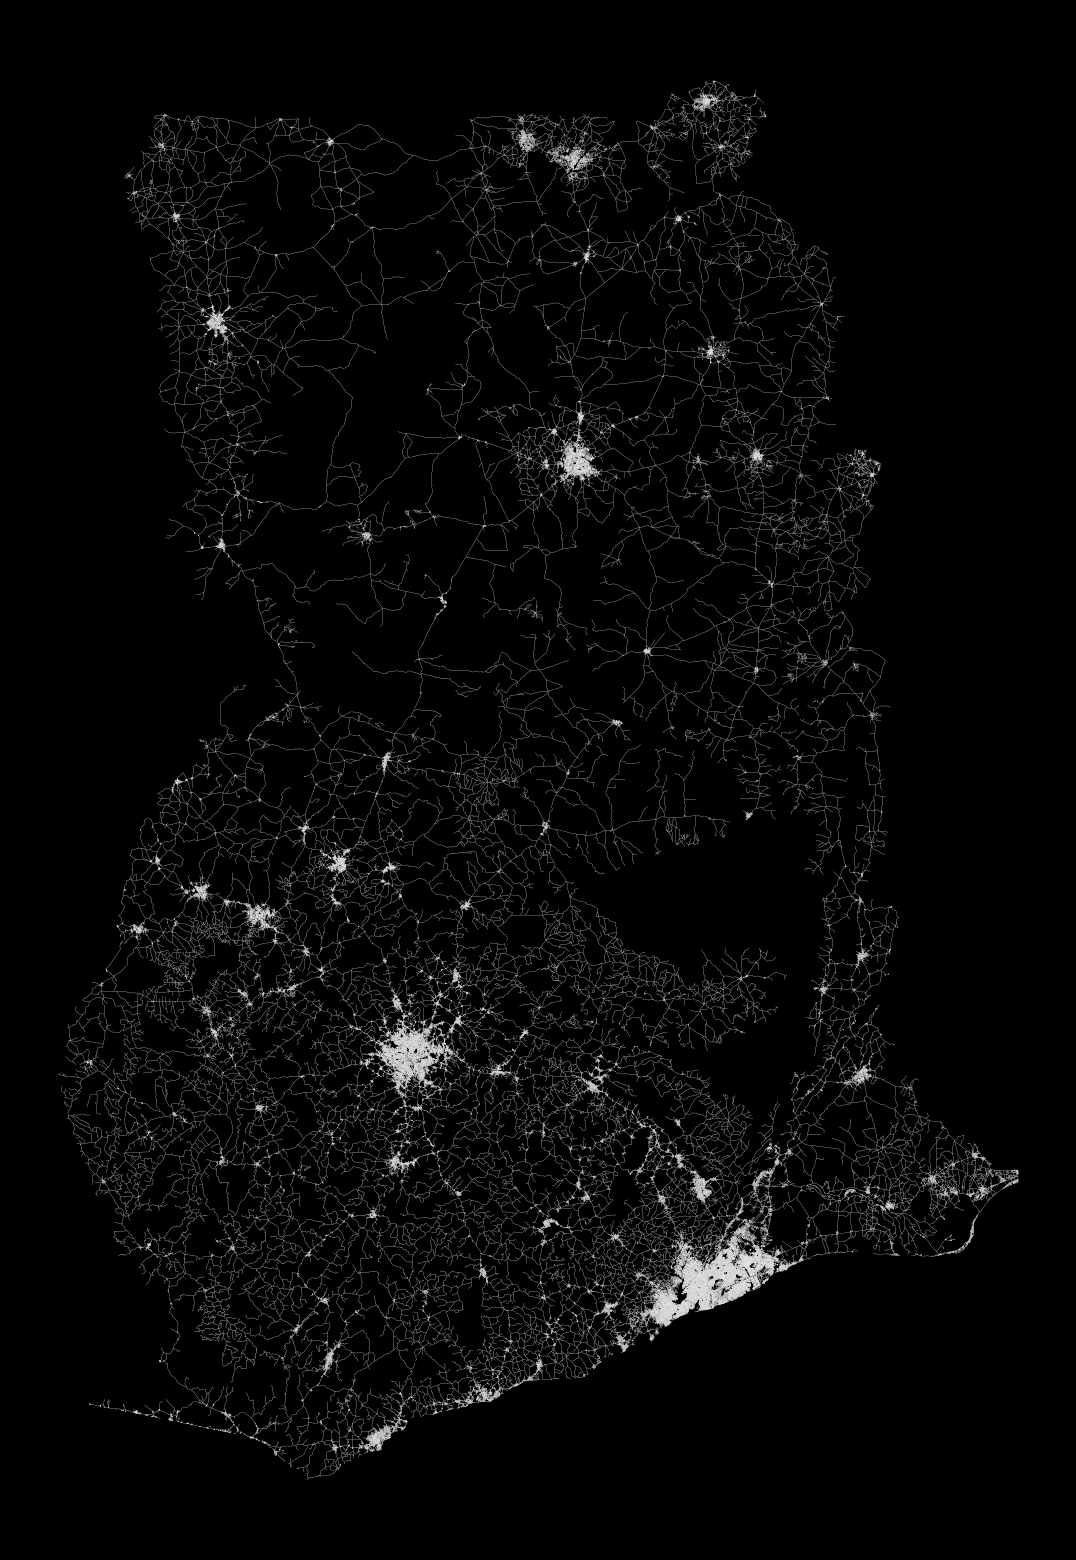

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20), facecolor = 'k')

E.plot(color='w', ax=ax, linewidth=0.1)
ax.set_axis_off()
ax.set_facecolor('k')

In [8]:
# download all hospitals in Ghana using osmnx
hospitals = ox.features_from_place('Ghana', tags={'amenity': 'hospital'})
hospitals.head()

/usr/local/lib/python3.11/dist-packages/osmnx/_overpass.py:267: UserWarning: This area is 116 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


geometry   amenity  \
element id                                               
node    1791548336  POINT (-0.85086 9.40192)  hospital   
        2148020987  POINT (-0.21536 5.63542)  hospital   
        2154259341   POINT (-0.1149 5.72504)  hospital   
        4286153094  POINT (-0.03708 5.71087)  hospital   
        4621957790  POINT (-1.67698 6.66119)  hospital   

                                           name addr:city addr:postcode  \
element id                                                                
node    1791548336         Tamale West Hospital       NaN           NaN   
        2148020987     Lapaz Community Hospital       NaN           NaN   
        2154259341  Sweden Ghana Medical Centre       NaN           NaN   
        4286153094  Ashaiman Community Hospital       NaN           NaN   
        4621957790        Aburaso Health center       NaN           NaN   

                   addr:street emergency healthcare healthcare:speciality  \
element id                                                                  
node    1791548336         NaN       yes   hospital                   NaN   
        2148020987         NaN       NaN   hospital                   NaN   
        2154259341         NaN       NaN   hospital                   NaN   
        4286153094         NaN       NaN   hospital                   NaN   
        4621957790         NaN       NaN        NaN                   NaN   

                   addr:housenumber  ... addr:community building:material  \
element id                           ...                                    
node    1791548336              NaN  ...            NaN               NaN   
        2148020987              NaN  ...            NaN               NaN   
        2154259341              NaN  ...            NaN               NaN   
        4286153094              NaN  ...            NaN               NaN   
        4621957790              NaN  ...            NaN               NaN   

                   roof:material note start_date  fax mobile landuse barrier  \
element id                                                                     
node    1791548336           NaN  NaN        NaN  NaN    NaN     NaN     NaN   
        2148020987           NaN  NaN        NaN  NaN    NaN     NaN     NaN   
        2154259341           NaN  NaN        NaN  NaN    NaN     NaN     NaN   
        4286153094           NaN  NaN        NaN  NaN    NaN     NaN     NaN   
        4621957790           NaN  NaN        NaN  NaN    NaN     NaN     NaN   

                   addr:place  
element id                     
node    1791548336        NaN  
        2148020987        NaN  
        2154259341        NaN  
        4286153094        NaN  
        4621957790        NaN  

[5 rows x 75 columns]

In [9]:
len(hospitals)

445

In [11]:
hospitals = hospitals.to_crs(4326)
hospitals['lat'] = hospitals['geometry'].centroid.y
hospitals['lon'] = hospitals['geometry'].centroid.x
hospitals = hospitals.to_crs(3857)
hospitals['x'] = hospitals['geometry'].centroid.x
hospitals['y'] = hospitals['geometry'].centroid.y

<ipython-input-11-a95fb85ec8ec>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hospitals['lat'] = hospitals['geometry'].centroid.y
<ipython-input-11-a95fb85ec8ec>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hospitals['lon'] = hospitals['geometry'].centroid.x


In [12]:
# get the nearest network node to each point
hospitals['nodes'] = ox.nearest_nodes(G, hospitals['lon'], hospitals['lat'])

In [14]:
# get the shortest paths from all the nodes to all the entraces nodes
%time lines = nx.multi_source_dijkstra_path(G, set(hospitals['nodes'].to_numpy()), weight='length')
# voronoi cells creates a voronoi using the network rather than euclidean distance
%time cells = nx.voronoi_cells(G, set(hospitals['nodes'].to_numpy()), weight='length')

CPU times: user 5.36 s, sys: 36.7 ms, total: 5.4 s
Wall time: 5.39 s
CPU times: user 6.07 s, sys: 51.9 ms, total: 6.12 s
Wall time: 6.11 s


In [15]:
cells = [pd.DataFrame({'parent': x[0], 'child': list(x[1])}) for x in cells.items()]
merged = pd.concat(cells).merge(N, left_on='child', right_on='osmid', how='left')

In [39]:
n = merged['parent'].value_counts().reset_index()
n['log_count'] = np.log(n['count'] + 1)
n

parent  count  log_count
0     4458123470   9337   9.141847
1     4698305204   7796   8.961494
2     3681436563   6534   8.784928
3     5541257068   6309   8.749891
4     5880910844   5446   8.602820
..           ...    ...        ...
427    120295900      7   2.079442
428   2400215372      5   1.791759
429   5974688062      4   1.609438
430   5941799407      1   0.693147
431  10290478903      1   0.693147

[432 rows x 3 columns]

In [16]:
import colorcet as cc

Text(0.5, 1.0, 'Hospital Catchments')

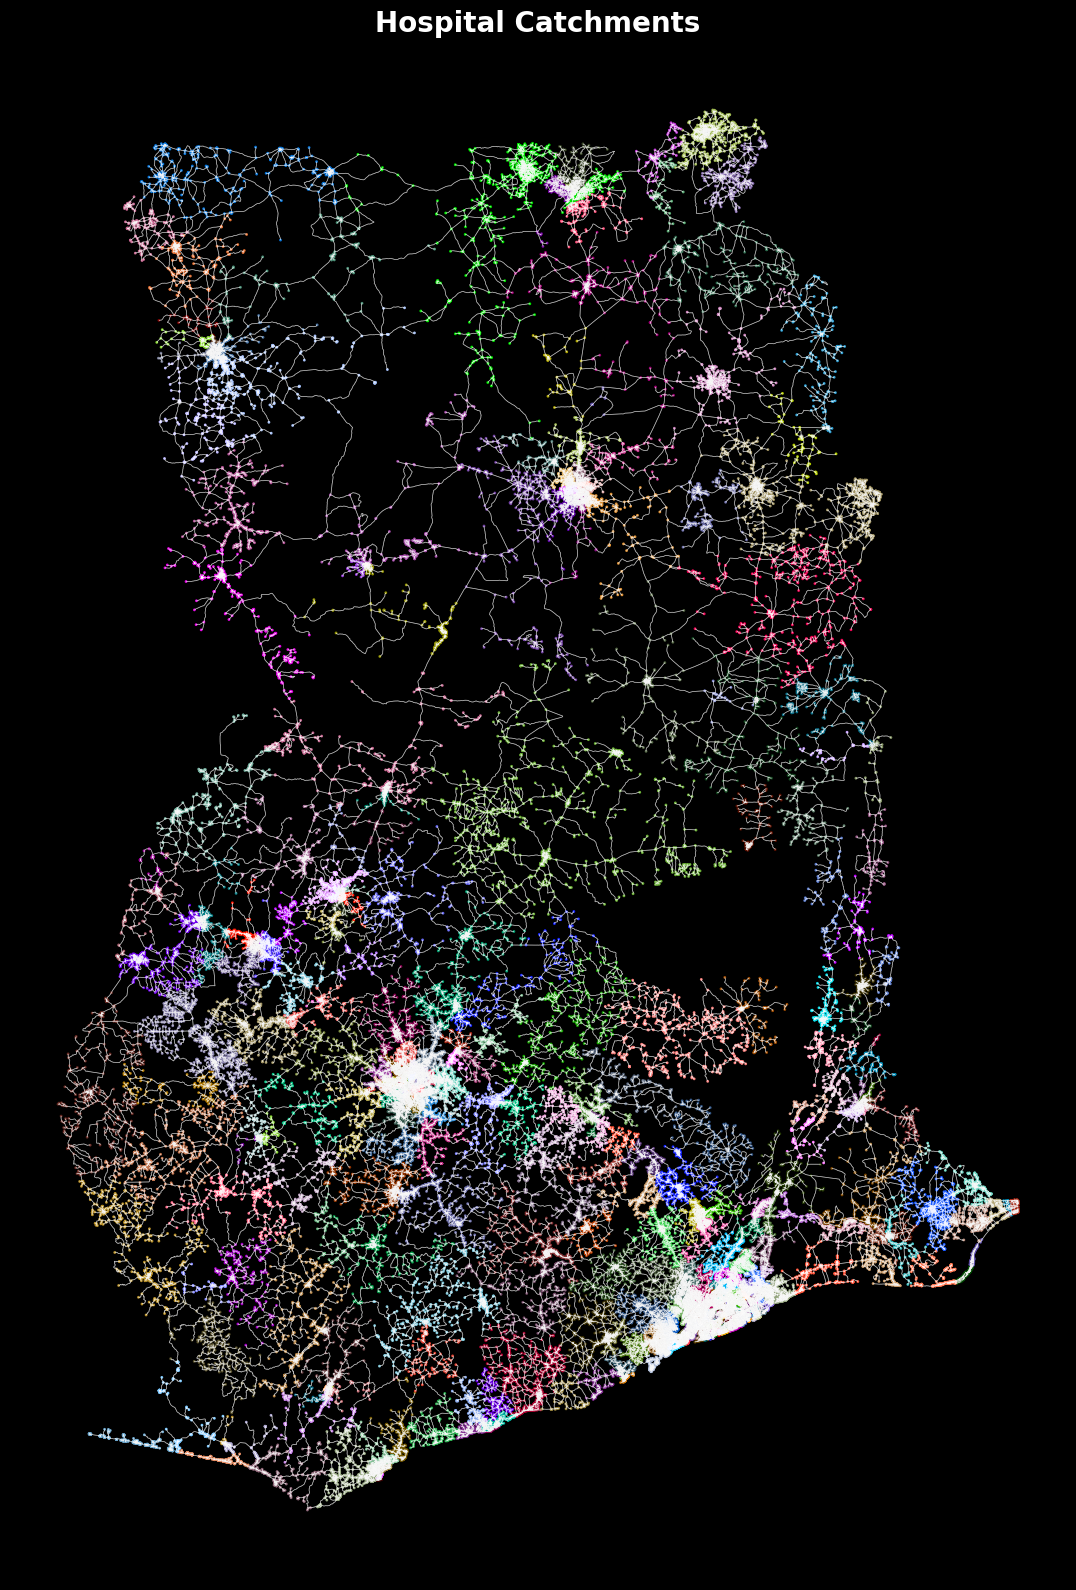

In [40]:
# plot the edges in black
fig, ax = plt.subplots(figsize=(20, 20), facecolor='k')
E.plot(color='w', ax=ax, linewidth=0.5, alpha=0.5)

# convert the merge cell dataframe to a geodataframe and plot it
gpd.GeoDataFrame(merged,
                 geometry=gpd.points_from_xy(merged['x'], merged['y']),
                 crs=4326).to_crs('3857').plot('parent', markersize=1, cmap=cc.cm.glasbey_dark, ax=ax)

# plot the stores in light grey to highlight them
hospitals.merge(n, left_on='nodes', right_on='parent').plot(color='w', ax=ax, markersize='log_count', alpha=0.5)

# clean it up
ax.set_axis_off()
ax.set_facecolor('k')

# add a title
ax.set_title('Hospital Catchments', fontsize=20, fontweight='bold', color='w')

In [41]:
# let's check the distances to shops from all nodes
%time lengths = nx.multi_source_dijkstra_path_length(G, set(hospitals['nodes'].to_numpy()), weight="length")

CPU times: user 4.87 s, sys: 32.9 ms, total: 4.9 s
Wall time: 4.92 s


In [42]:
# make a data frame of the lengths
lengths = pd.DataFrame({'osmid':lengths.keys(), 'distance': lengths.values()})
# there seem to be some outliers, let's remove them
lengths = lengths[lengths['distance'] < 100000]

In [43]:
# what is the average length
int(lengths['distance'].mean())

8514

Text(0.5, 1.0, 'Hospital Distances')

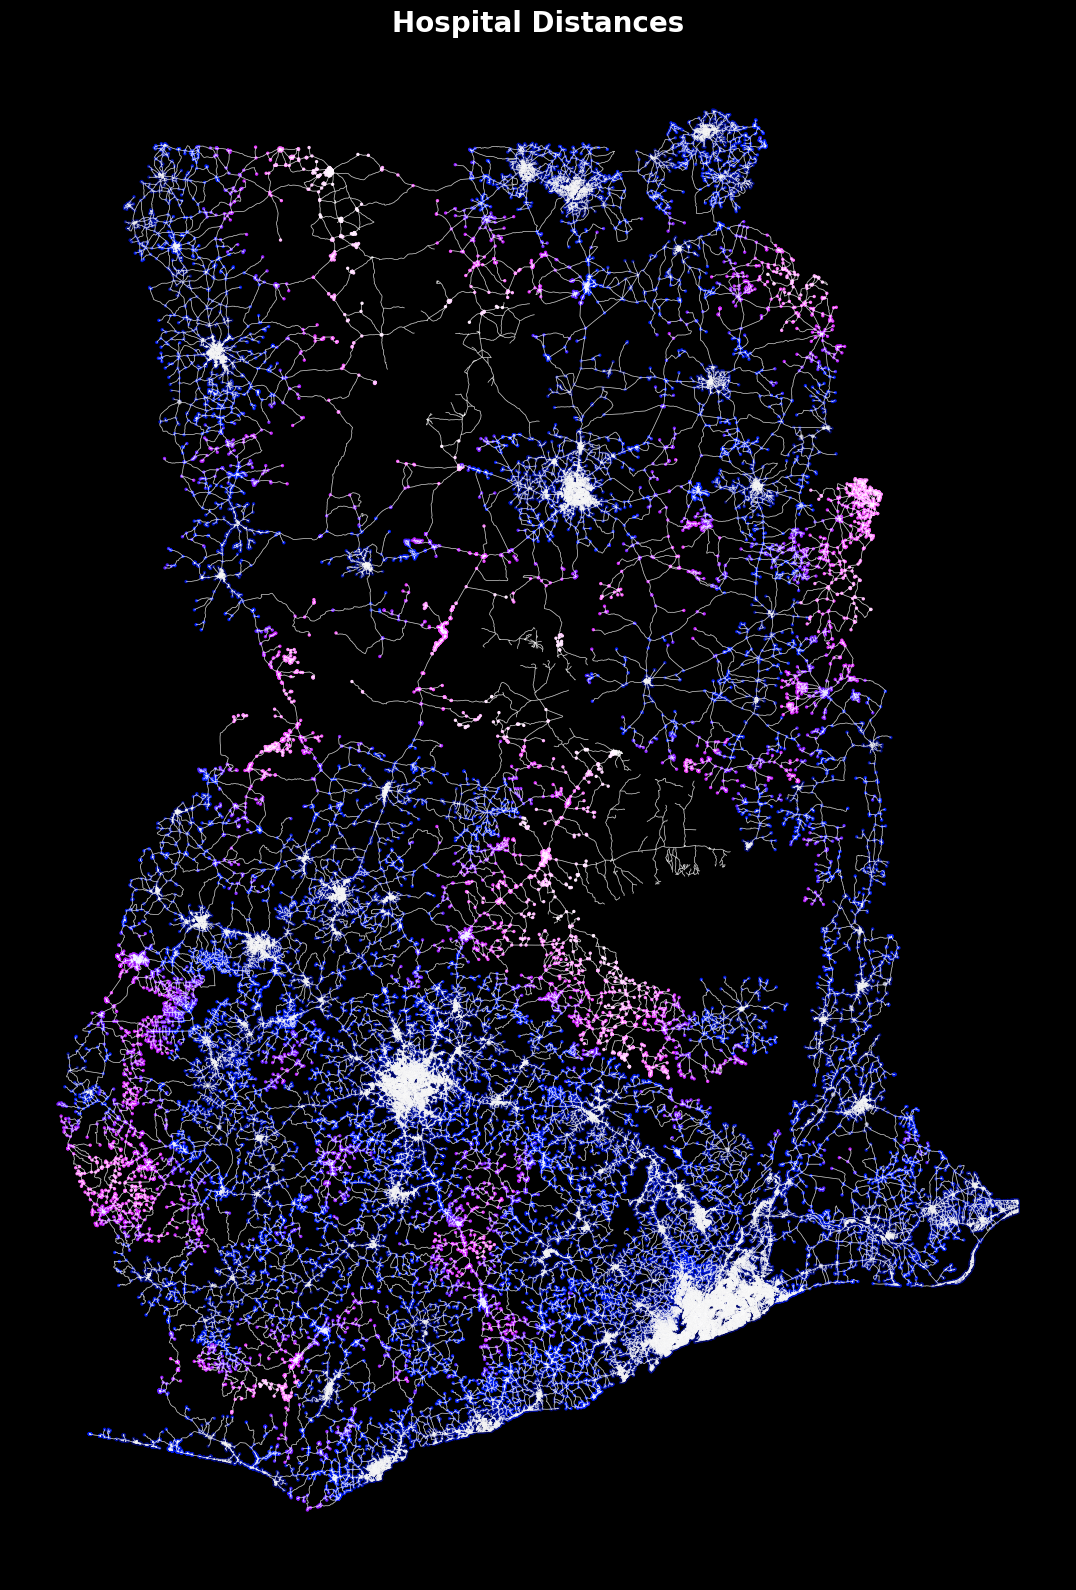

In [45]:
# same as before but with distance as the column of interest
fig, ax = plt.subplots(figsize=(20, 20), facecolor='k')
E.plot(color='w', ax=ax, linewidth=0.5, alpha=0.5)
gpd.GeoDataFrame(merged,
                 geometry=gpd.points_from_xy(merged['x'], merged['y']),
                 crs=4326).to_crs('3857').merge(lengths, left_on='child',
                                                right_on='osmid',
                                                how='left').plot('distance', markersize=2, cmap=cc.cm.bmw, ax=ax)

# plot the stores in light grey to highlight them
hospitals.merge(n, left_on='nodes', right_on='parent').plot(color='w', ax=ax, markersize='log_count', alpha=0.5)

# clean it up
ax.set_axis_off()
ax.set_facecolor('k')

# add a title
ax.set_title('Hospital Distances', fontsize=20, fontweight='bold', color='w')